In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [3]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice, shielding their denominators
    with np.errstate(divide='ignore', invalid='ignore'):
        # Level-1 imbalance
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den>0, num/den, np.nan)
        
        # Book pressure (L1+L2)
        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2>0, num2/den2, np.nan)
        
        # Microprice
        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den>0, num3/den, np.nan)
    
    # 3. normalized_spread & L2 order‐book imbalance
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(
        den2>0,
        (df['bid_size1'] + df['bid_size2']) / den2,
        np.nan
    )
    
    # 4. entropy of the LOB
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p     = np.divide(sizes, total, where=total!=0)
    entropy = -np.nansum(np.where(p>0, p*np.log(p), 0), axis=1)
    df['LOB_entropy']            = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)
    
    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 5a. realized_volatility over past-30 ticks (no leakage)
    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: 
              np.sqrt((x.shift(1)**2)           # <-- shift here
                       .rolling(window=30, min_periods=1) # window size
                       .sum())
          )
    )

    # 5b. bipower variance over past-30 ticks
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: 
              x.abs()
               .shift(1)                        # only prior returns
               .rolling(2, min_periods=1)
               .apply(lambda r: r[0]*r[1], raw=True)
               .rolling(30, min_periods=1) # window size
               .mean()
          )
    )

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df.dropna()

In [4]:
df = make_features(df)

In [5]:
def add_target(df: pd.DataFrame, horizon: int = 30) -> pd.DataFrame:

    fwd_ret = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x.shift(-1) / x))
    )
    df['rv_future'] = (
        fwd_ret.pow(2)
                .groupby(df['time_id'])
                .transform(lambda x: np.sqrt(x.rolling(horizon, 1).sum()))
    )
    # Drop the rows that would depend on data past the end of the bucket
    df = df.groupby('time_id').apply(
        lambda g: g.iloc[:-horizon] if len(g) > horizon else g.iloc[0:0]
    ).reset_index(drop=True)
    return df.dropna(subset=['rv_future'])

In [6]:
df = add_target(df, horizon=30)

/var/folders/0s/bt69j7tj0pd5rl5dzr4n6bth0000gn/T/ipykernel_2256/39068516.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('time_id').apply(


In [7]:
feature_cols = [
    'mid_price','spread','imbalance','book_pressure','microprice',
    'normalized_spread','OBI_L2','LOB_entropy','LOB_entropy_normalized','bipower_var'
]
X = df[feature_cols]
y = df['rv_future']

In [8]:
cutoff_time_ids = sorted(df['time_id'].unique())
train_ids, test_ids = cutoff_time_ids[:-int(len(cutoff_time_ids)*0.2)], cutoff_time_ids[-int(len(cutoff_time_ids)*0.2):]
train_mask = df['time_id'].isin(train_ids)
X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[~train_mask], y[~train_mask]

In [9]:
rf = RandomForestRegressor(
    n_estimators      = 500,
    max_depth         = 15,
    min_samples_leaf  = 5,
    n_jobs            = -1,
    random_state      = 42,
    verbose           = 1
)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 500building tree 2 of 500

building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.4s


building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min


building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.8min


building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished


RandomForestRegressor(max_depth=15, min_samples_leaf=5, n_estimators=500,
                      n_jobs=-1, random_state=42, verbose=2)

In [10]:
pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, pred)
print(f"Out-of-sample RMSE = {rmse:.6f}")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.1s


Out-of-sample RMSE = 0.000412


[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.4s finished


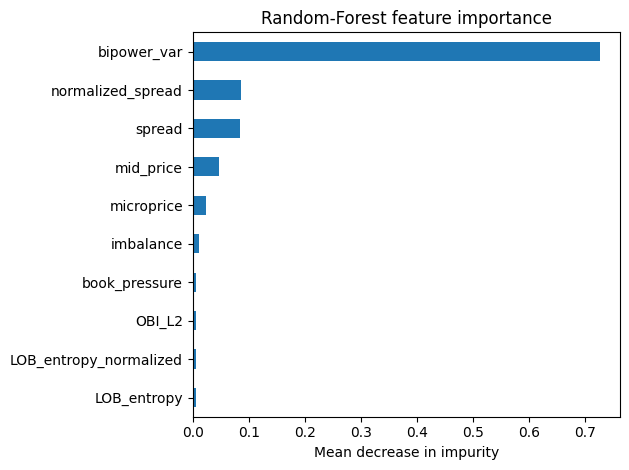

In [11]:
imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure()
imp.sort_values(ascending=True).plot(kind="barh")
plt.title("Random-Forest feature importance")
plt.xlabel("Mean decrease in impurity")
plt.tight_layout()
plt.show()

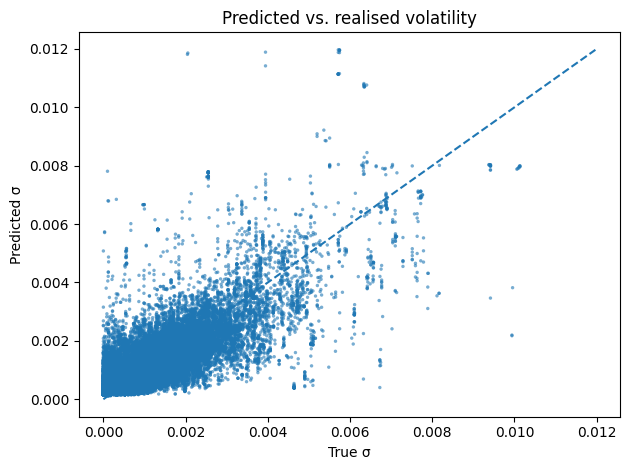

In [12]:
plt.figure()
plt.scatter(y_test, pred, s=6, alpha=0.6, edgecolor="none")
max_val = max(np.max(y_test), np.max(pred))
plt.plot([0, max_val], [0, max_val], linestyle="--")
plt.title("Predicted vs. realised volatility")
plt.xlabel("True σ")
plt.ylabel("Predicted σ")
plt.tight_layout()
plt.show()

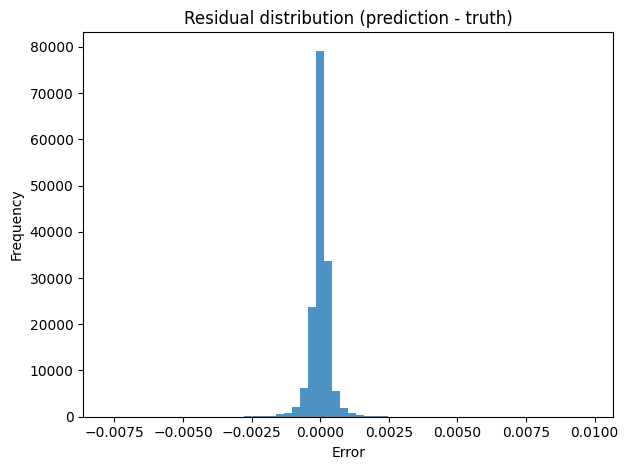

In [13]:
residuals = pred - y_test
plt.figure()
plt.hist(residuals, bins=60, alpha=0.8)
plt.title("Residual distribution (prediction - truth)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()